In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from imageio import imread
import scipy.io
import cv2
import pickle
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [3]:
batch_size = 1
maxlen = 20
image_size = 224

MEAN_VALUES = np.array([123.68, 116.779, 103.939]).reshape((1, 1, 3))

with open('dictionary.pkl', 'rb') as fr:
    [vocabulary, word2id, id2word] = pickle.load(fr)

In [4]:
def translate(ids):
    words = [id2word[i] for i in ids if i >= 3]
    return ' '.join(words) + ' .'


In [5]:
vgg = scipy.io.loadmat('imagenet-vgg-verydeep-19.mat')
vgg_layers = vgg['layers']

def vgg_endpoints(inputs, reuse=None):
    with tf.variable_scope('endpoints', reuse=reuse):
        def _weights(layer, expected_layer_name):
            W = vgg_layers[0][layer][0][0][2][0][0]
            b = vgg_layers[0][layer][0][0][2][0][1]
            layer_name = vgg_layers[0][layer][0][0][0][0]
            assert layer_name == expected_layer_name
            return W, b

        def _conv2d_relu(prev_layer, layer, layer_name):
            W, b = _weights(layer, layer_name)
            W = tf.constant(W)
            b = tf.constant(np.reshape(b, (b.size)))
            return tf.nn.relu(tf.nn.conv2d(prev_layer, filter=W, strides=[1, 1, 1, 1], padding='SAME') + b)

        def _avgpool(prev_layer):
            return tf.nn.avg_pool(prev_layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

        graph = {}
        graph['conv1_1']  = _conv2d_relu(inputs, 0, 'conv1_1')
        graph['conv1_2']  = _conv2d_relu(graph['conv1_1'], 2, 'conv1_2')
        graph['avgpool1'] = _avgpool(graph['conv1_2'])
        graph['conv2_1']  = _conv2d_relu(graph['avgpool1'], 5, 'conv2_1')
        graph['conv2_2']  = _conv2d_relu(graph['conv2_1'], 7, 'conv2_2')
        graph['avgpool2'] = _avgpool(graph['conv2_2'])
        graph['conv3_1']  = _conv2d_relu(graph['avgpool2'], 10, 'conv3_1')
        graph['conv3_2']  = _conv2d_relu(graph['conv3_1'], 12, 'conv3_2')
        graph['conv3_3']  = _conv2d_relu(graph['conv3_2'], 14, 'conv3_3')
        graph['conv3_4']  = _conv2d_relu(graph['conv3_3'], 16, 'conv3_4')
        graph['avgpool3'] = _avgpool(graph['conv3_4'])
        graph['conv4_1']  = _conv2d_relu(graph['avgpool3'], 19, 'conv4_1')
        graph['conv4_2']  = _conv2d_relu(graph['conv4_1'], 21, 'conv4_2')
        graph['conv4_3']  = _conv2d_relu(graph['conv4_2'], 23, 'conv4_3')
        graph['conv4_4']  = _conv2d_relu(graph['conv4_3'], 25, 'conv4_4')
        graph['avgpool4'] = _avgpool(graph['conv4_4'])
        graph['conv5_1']  = _conv2d_relu(graph['avgpool4'], 28, 'conv5_1')
        graph['conv5_2']  = _conv2d_relu(graph['conv5_1'], 30, 'conv5_2')
        graph['conv5_3']  = _conv2d_relu(graph['conv5_2'], 32, 'conv5_3')
        graph['conv5_4']  = _conv2d_relu(graph['conv5_3'], 34, 'conv5_4')
        graph['avgpool5'] = _avgpool(graph['conv5_4'])

        return graph


In [6]:

X = tf.placeholder(tf.float32, [None, image_size, image_size, 3])
encoded = vgg_endpoints(X - MEAN_VALUES)['conv5_3']

k_initializer = tf.contrib.layers.xavier_initializer()
b_initializer = tf.constant_initializer(0.0)
e_initializer = tf.random_uniform_initializer(-1.0, 1.0)

In [7]:
def dense(inputs, units, activation=tf.nn.tanh, use_bias=True, name=None):
    return tf.layers.dense(inputs, units, activation, use_bias,
                           kernel_initializer=k_initializer, bias_initializer=b_initializer, name=name)


In [8]:
def batch_norm(inputs, name):
    return tf.contrib.layers.batch_norm(inputs, decay=0.95, center=True, scale=True, is_training=False,
                                        updates_collections=None, scope=name)


In [9]:
def dropout(inputs):
    return tf.layers.dropout(inputs, rate=0.5, training=False)


In [10]:
num_block = 14 * 14
num_filter = 512
hidden_size = 1024
embedding_size = 512

encoded = tf.reshape(encoded, [-1, num_block, num_filter]) # batch_size, num_block, num_filter
contexts = batch_norm(encoded, 'contexts')

with tf.variable_scope('initialize'):
    context_mean = tf.reduce_mean(contexts, 1)
    initial_state = dense(context_mean, hidden_size, name='initial_state')
    initial_memory = dense(context_mean, hidden_size, name='initial_memory')

contexts_phr = tf.placeholder(tf.float32, [None, num_block, num_filter])
last_memory = tf.placeholder(tf.float32, [None, hidden_size])
last_state = tf.placeholder(tf.float32, [None, hidden_size])
last_word = tf.placeholder(tf.int32, [None])

with tf.variable_scope('embedding'):
    embeddings = tf.get_variable('weights', [len(word2id), embedding_size], initializer=e_initializer)
    embedded = tf.nn.embedding_lookup(embeddings, last_word)

with tf.variable_scope('projected'):
    projected_contexts = tf.reshape(contexts_phr, [-1, num_filter]) # batch_size * num_block, num_filter
    projected_contexts = dense(projected_contexts, num_filter, activation=None, use_bias=False, name='projected_contexts')
    projected_contexts = tf.reshape(projected_contexts, [-1, num_block, num_filter]) # batch_size, num_block, num_filter

lstm = tf.nn.rnn_cell.BasicLSTMCell(hidden_size)

with tf.variable_scope('attend'):
    h0 = dense(last_state, num_filter, activation=None, name='fc_state') # batch_size, num_filter
    h0 = tf.nn.relu(projected_contexts + tf.expand_dims(h0, 1)) # batch_size, num_block, num_filter
    h0 = tf.reshape(h0, [-1, num_filter]) # batch_size * num_block, num_filter
    h0 = dense(h0, 1, activation=None, use_bias=False, name='fc_attention') # batch_size * num_block, 1
    h0 = tf.reshape(h0, [-1, num_block]) # batch_size, num_block

    alpha = tf.nn.softmax(h0) # batch_size, num_block
    # contexts:                 batch_size, num_block, num_filter
    # tf.expand_dims(alpha, 2): batch_size, num_block, 1
    context = tf.reduce_sum(contexts_phr * tf.expand_dims(alpha, 2), 1, name='context') # batch_size, num_filter

with tf.variable_scope('selector'):
    beta = dense(last_state, 1, activation=tf.nn.sigmoid, name='fc_beta') # batch_size, 1
    context = tf.multiply(beta, context, name='selected_context')  # batch_size, num_filter

with tf.variable_scope('lstm'):
    h0 = tf.concat([embedded, context], 1) # batch_size, embedding_size + num_filter
    _, (current_memory, current_state) = lstm(inputs=h0, state=[last_memory, last_state])

with tf.variable_scope('decode'):
    h0 = dropout(current_state)
    h0 = dense(h0, embedding_size, activation=None, name='fc_logits_state')
    h0 += dense(context, embedding_size, activation=None, use_bias=False, name='fc_logits_context')
    h0 += embedded
    h0 = tf.nn.tanh(h0)

    h0 = dropout(h0)
    logits = dense(h0, len(word2id), activation=None, name='fc_logits')
    probs = tf.nn.softmax(logits)

In [11]:
MODEL_DIR = 'model'
sess = tf.Session()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
saver.restore(sess, tf.train.latest_checkpoint(MODEL_DIR))

beam_size = 3
img = imread('sample.jpg')
if img.shape[-1] == 4:
    img = img[:, :, :-1]
h = img.shape[0]
w = img.shape[1]
if h > w:
    img = img[h // 2 - w // 2: h // 2 + w // 2, :]
else:
    img = img[:, w // 2 - h // 2: w // 2 + h // 2]
img = cv2.resize(img, (image_size, image_size))
X_data = np.expand_dims(img, 0)

contexts_, initial_memory_, initial_state_ = sess.run([contexts, initial_memory, initial_state], feed_dict={X: X_data})

result = [{
    'sentence': [],
    'memory': initial_memory_[0],
    'state': initial_state_[0],
    'score': 1.0,
    'alphas': []
}]
complete = []
for t in range(maxlen + 1):
    cache = []
    step = 1 if t == 0 else beam_size
    for s in range(step):
        if t == 0:
            last_word_ = np.ones([batch_size], np.int32) * word2id['<start>']
        else:
            last_word_ = np.array([result[s]['sentence'][-1]], np.int32)

        last_memory_ = np.array([result[s]['memory']], np.float32)
        last_state_ = np.array([result[s]['state']], np.float32)

        current_memory_, current_state_, probs_, alpha_ = sess.run(
            [current_memory, current_state, probs, alpha], feed_dict={
                contexts_phr: contexts_,
                last_memory: last_memory_,
                last_state: last_state_,
                last_word: last_word_
                })

        word_and_probs = [[w, p] for w, p in enumerate(probs_[0])]
        word_and_probs.sort(key=lambda x:-x[1])
        word_and_probs = word_and_probs[:beam_size + 1]

        for w, p in word_and_probs:
            item = {
                'sentence': result[s]['sentence'] + [w],
                'memory': current_memory_[0],
                'state': current_state_[0],
                'score': result[s]['score'] * p,
                'alphas': result[s]['alphas'] + [alpha_[0]]
            }
            if id2word[w] == '<end>':
                complete.append(item)
            else:
                cache.append(item)

    cache.sort(key=lambda x:-x['score'])
    cache = cache[:beam_size]
    result = cache.copy()

if len(complete) == 0:
    final_sentence = result[0]['sentence']
    alphas = result[0]['alphas']
else:
    final_sentence = complete[0]['sentence']
    alphas = complete[0]['alphas']

sentence = translate(final_sentence)
print(sentence)
sentence = sentence.split(' ')

a brown and white dog running in the grass .


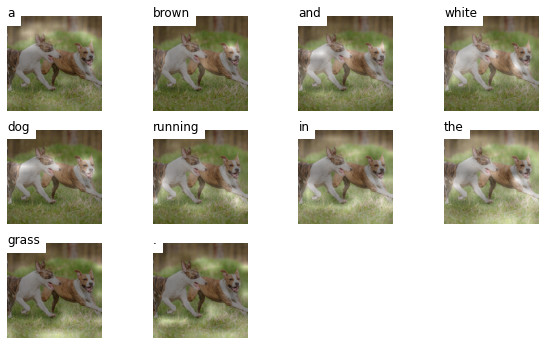

In [12]:
img = (img - img.min()) / (img.max() - img.min())
n = int(np.ceil(np.sqrt(len(sentence))))
plt.figure(figsize=(10, 8))
for i in range(len(sentence)):
    word = sentence[i]
    a = np.reshape(alphas[i], (14, 14))
    a = cv2.resize(a, (image_size, image_size))
    a = np.expand_dims(a, -1)
    a = (a - a.min()) / (a.max() - a.min())
    combine = 0.5 * img +  0.5 * a
    plt.subplot(n, n, i + 1)
    plt.text(0, 1, word, color='black', backgroundcolor='white', fontsize=12)
    plt.imshow(combine)
    plt.axis('off')
plt.show()
